In [1]:
from IPython.core.display import HTML
def css_styling():
    styles = open("custom.css", "r").read()
    return HTML(styles)
css_styling()
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid, cm
import pandas as pd
import numpy as np
import netCDF4
from matplotlib.ticker import MultipleLocator
from scipy.interpolate import *

In [3]:
filename='/Users/ptg21/data/projects/Blowsea/ancil_creation/ACTM_T42L67_GeoPotHgt_regrid_N48.nc'
ncfilea     = netCDF4.Dataset(filename)
lona        = ncfilea.variables['longitude'][:]
lata        = ncfilea.variables['latitude'][:] 
timesa      = ncfilea.variables['time']
GeoPH       = ncfilea.variables['Z'][:,:,:,:]
nmonthsa, nlevelsa, nya, nxa = np.shape(GeoPH)

In [4]:
new_GeoPH = np.empty_like(GeoPH)
for ivar in range (nya-1,0,-1):
    new_GeoPH [:,:,ivar,:] = GeoPH[:,:,nya-ivar,:]

In [5]:
filename='/Users/ptg21/data/projects/blowsea/ancil_creation/ACTM_T42L67_O1D_N48_regrid.nc'
ncfile1    = netCDF4.Dataset(filename)
lon1        = ncfile1.variables['longitude'][:]
lat1        = ncfile1.variables['latitude'][:] 
level1      = ncfile1.variables['level'][:] # sigma
times1      = ncfile1.variables['time']
NDOD        = ncfile1.variables['NDOD'][:,:,:,:]
nmonths, nlevels, ny1, nx1 = np.shape(NDOD)
nboundaries = nlevels + 1
nx1 = len(lon1)
ny1 = len(lat1)
new_NDOD = np.empty_like(NDOD)
for ivar in range (nya-1,0,-1):
    new_NDOD [:,:,ivar,:] = NDOD[:,:,nya-ivar,:]

In [6]:
# get file containing heights, pressures for L85 ancil
filename='/Users/ptg21/data/projects/blowsea/ancil_creation/xjcira.p.nc'
ncfile2     = netCDF4.Dataset(filename)
 
lon_in        = ncfile2.variables['longitude'][:]
lat_in        = ncfile2.variables['latitude'][:]
press_in      = ncfile2.variables['p'][:]
hybrid_ht_in  = ncfile2.variables['hybrid_ht'][:]
time2_in      = ncfile2.variables['t'][:]
nmonths2_in, nheights_in, ny2_in, nx2_in = np.shape(press_in)


In [13]:
new_res=np.empty_like(press_in)

# these are the data from which the data are to be interpolated onto
err_string=''
for imonth in range (0, 12):
    print imonth
    for ilat in range (0, ny1):
        for ilon in range (0, nx1):
            xold = new_GeoPH[imonth, :, ilat, ilon]
            yold = new_NDOD [imonth, :, ilat, ilon]
            if xold.min() == xold.max():
                #err_string = err_string + "FAIL - can't do interpolation for " + str(ilat) +","+ str(ilon)
                new_res[imonth, :, ilat, ilon] = xold.min()
            else:
                xnew = hybrid_ht_in
                interpol_fn=interp1d(xold, yold, kind='linear' )
                interpold_data  = np.zeros((0),float)
                for ivar in range(0, len(xnew)):
                    if xnew[ivar]< xold.min():
                        #err_string = err_string + "INSUFFICENT RANGE lat=" + str(ilat) + " lon=" + str(ilon) + " " + str(xnew[ivar])\
                        #+ " " + str(xold.min()) + "\n"
                        interpold_data  = np.append(interpold_data,[interpol_fn.__call__(xold.min() )],axis=0)
                    elif xnew[ivar] > xold.max():
                        interpold_data  = np.append(interpold_data,[interpol_fn.__call__(xold.max() )],axis=0)
                        #err_string = err_string + "INSUFFICENT RANGE lat=" + str(ilat) + " lon=" + str(ilon) +" " + str(xnew[ivar])\
                        #+ " " + str(xold.max()) + "\n"
                    else:
                        interpold_data  = np.append(interpold_data,[interpol_fn.__call__(xnew[ivar] )],axis=0)
                new_res[imonth, :, ilat, ilon] = interpold_data[:]

0
1
2
3
4
5
6
7
8
9
10
11


In [14]:
np.save('O1D_interp',new_res)

In [7]:
new_data=np.load('O1D_interp.npy')

In [8]:
%%bash
rm -Rf fieldO1D.nc

In [9]:
# to be fixed

from netCDF4 import Dataset
import time
# Create HDF5 *format*, classic *model*
dataset = Dataset('fieldO1D.nc', 'w', format='NETCDF4')

# Global Attributes
dataset.description = 'TEST NETCDF-CF COMPLIANT SCRIPT'
dataset.history = 'Created ' + time.ctime(time.time())
dataset.source = ''
dataset.Conventions = 'CF-1.0'
dataset.standard_name_vocabulary='CF-1.0'

height = dataset.createDimension('hybrid_ht', nheights_in) # add bottom level
height = dataset.createVariable('hybrid_ht',    np.int32,   ('hybrid_ht',))

time  = dataset.createDimension('time',      None)
time  = dataset.createVariable('time',       'f8', ('time',)) # or can use np as below

lat   = dataset.createDimension('latitude',  ny2_in)
lat   = dataset.createVariable('latitude',   np.float32, ('latitude',))

lon   = dataset.createDimension('longitude', nx2_in)
lon   = dataset.createVariable('longitude',  np.float32, ('longitude',))

fieldO1D_out = dataset.createVariable('fieldO1D', np.float32, ('time','hybrid_ht','latitude', 'longitude',))

lon[:]   = lon_in[:]
lat[:]   = lat_in[:]
height[:] = hybrid_ht_in[:]
time[:]  = time2_in[:]

fieldO1D_out[:,:,:,:] = new_data[:,:,:,:]


# Variable Attributes
lat.standard_name = 'latitude'
lat.units = 'degrees_north'
lat.cartesian_axis = "Y"
lat.axis = 'Y'
lat.actual_range = -90.0, 90.0

lon.standard_name = 'longitude'
lon.units = 'degrees_east'
lon.cartesian_axis = "X"
lon.axis = "X"
lat.actual_range = 0.0, 360.0

fieldO1D_out.units = 'molecules / cm-3'
fieldO1D_out.standard_name='O1D_mixing_ratio'

height.units = 'm'
height.axis='Z'
height.positive='up'
height.standard_name = 'hybrid_pressure_levels'


time.standard_name = 'time'
time.long_name = 'time'
time.units = 'days since 1999-12-01 00:00:00'
time.calendar = '360_day'
time.axis = 'T'
print ('success')
dataset.close()

success


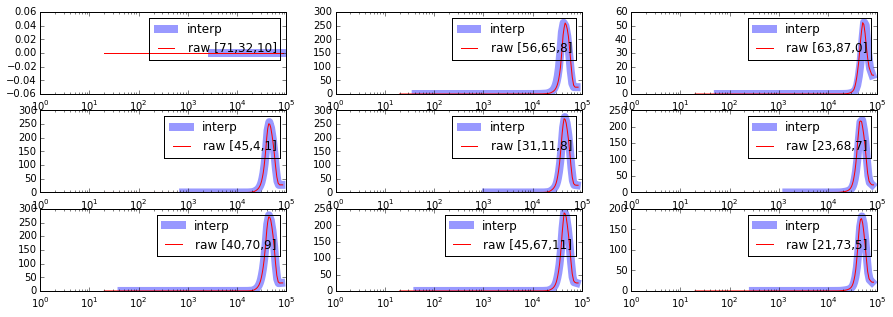

In [12]:
%matplotlib inline
from random import randint

plt.figure(figsize=(15,5))

for ivar in range (1,10):
    plt.subplot(3,3,ivar)
    month=randint(0,nmonths-1)
    lat=randint(0,ny1-1)
    lon=randint(0,nx1-1)
    plt.semilogx(GeoPH[month,:,lat,lon],new_NDOD[month,:,lat,lon], lw=8, alpha=0.4, label='interp')
    plt.semilogx(hybrid_ht_in[:],new_data[month,:,lat,lon],'r-', label='raw [' + str(lat)+","+str(lon)+","+str(month)+"]")
    plt.xlim([1,1e5])
    plt.legend()